## License 

Copyright 2020 Patrick Hall (jphall@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**DISCLAIMER:** This notebook is not legal compliance advice.

***

#### Global hyperpameters

In [7]:
SEED                    = 12345   # global random seed for better reproducibility
GLM_SELECTION_THRESHOLD = 0.001   # threshold above which a GLM coefficient is considered "selected"

#### Python imports and inits

In [8]:
from rmltk import explain, evaluate, model                        # simple module for training, explaining, and eval
import h2o                                                        # import h2o python bindings to h2o java server
import numpy as np                                                # array, vector, matrix calculations
import operator                                                   # for sorting dictionaries
import pandas as pd                                               # DataFrame handling
import time                                                       # for timers

import matplotlib.pyplot as plt      # plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# enables display of plots in notebook
%matplotlib inline

np.random.seed(SEED)                     # set random seed for better reproducibility

h2o.init(max_mem_size='24G', nthreads=4) # start h2o with plenty of memory and threads
h2o.remove_all()                         # clears h2o memory
h2o.no_progress()                        # turn off h2o progress indicators    

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 mins 30 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.5
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_User_2o24rl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,24 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


#### Start global timer

In [3]:
big_tic = time.time()

In [4]:
a=pd.read_csv('xtrain2.csv')
b=pd.read_csv('ytrain.csv')
#a.head()
c= a.drop(a.columns[0], axis=1)
c.head()

,var15,ind_var5,ind_var8_0,ind_var30,num_var5,num_var8_0,num_var30_0,num_var30,num_var42,saldo_var30,var36,num_meses_var5_ult3,num_var4,num_var35
0,23,0,0,0,0,0,3,0,0,0.00,99,0,0,0
1,34,0,0,1,0,0,6,3,0,300.00,3,1,1,3
2,23,1,0,1,3,0,3,3,3,3.00,99,3,1,3
3,37,1,0,1,3,0,3,3,3,70.62,2,2,3,9
4,39,0,0,1,0,0,6,3,3,135003.00,1,3,1,3


In [5]:
b.head()

,TARGET
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [6]:
d=pd.concat([c, b.reindex(a.index)], axis=1)

d.head()

,var15,ind_var5,ind_var8_0,ind_var30,num_var5,num_var8_0,num_var30_0,num_var30,num_var42,saldo_var30,var36,num_meses_var5_ult3,num_var4,num_var35,TARGET
0,23,0,0,0,0,0,3,0,0,0.00,99,0,0,0,0.0
1,34,0,0,1,0,0,6,3,0,300.00,3,1,1,3,0.0
2,23,1,0,1,3,0,3,3,3,3.00,99,3,1,3,0.0
3,37,1,0,1,3,0,3,3,3,70.62,2,2,3,9,0.0
4,39,0,0,1,0,0,6,3,3,135003.00,1,3,1,3,0.0


## 1. Download, Explore, and Prepare Data


#### Assign modeling roles
Notice that demographic features are not used as model inputs.

In [7]:
# assign target and inputs for models
y_name = 'TARGET'
x_names = [name for name in d.columns if name not in [y_name]]
print('y_name =', y_name)
print('x_names =', x_names)

y_name = TARGET
x_names = ['var15', 'ind_var5', 'ind_var8_0', 'ind_var30', 'num_var5', 'num_var8_0', 'num_var30_0', 'num_var30', 'num_var42', 'saldo_var30', 'var36', 'num_meses_var5_ult3', 'num_var4', 'num_var35']


In [8]:
len(x_names)

14

#### Display descriptive statistics

In [9]:
d.describe() 

,var15,ind_var5,ind_var8_0,ind_var30,num_var5,num_var8_0,num_var30_0,num_var30,num_var42,saldo_var30,var36,num_meses_var5_ult3,num_var4,num_var35,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.00000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000
mean,33.212865,0.663760,0.032833,0.732833,1.999171,0.09854,3.371863,2.382873,2.217995,1.367967e+04,40.449079,1.979979,1.079440,3.299369,0.039569
std,12.956486,0.472425,0.178202,0.442483,1.431902,0.53493,1.336654,1.642787,1.497703,6.301408e+04,47.362719,1.298924,0.909566,2.868217,0.194945
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-4.942260e+03,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,0.000000,0.000000,0.00000,3.000000,0.000000,0.000000,0.000000e+00,2.000000,0.000000,0.000000,0.000000,0.000000
50%,28.000000,1.000000,0.000000,1.000000,3.000000,0.00000,3.000000,3.000000,3.000000,3.000000e+00,3.000000,3.000000,1.000000,3.000000,0.000000
75%,40.000000,1.000000,0.000000,1.000000,3.000000,0.00000,3.000000,3.000000,3.000000,2.359950e+02,99.000000,3.000000,1.000000,3.000000,0.000000
max,105.000000,1.000000,1.000000,1.000000,15.000000,6.00000,114.000000,33.000000,18.000000,3.458077e+06,99.000000,3.000000,7.000000,36.000000,1.000000


In [10]:
d=pd.DataFrame(d[x_names + [y_name]])
d.head()

,var15,ind_var5,ind_var8_0,ind_var30,num_var5,num_var8_0,num_var30_0,num_var30,num_var42,saldo_var30,var36,num_meses_var5_ult3,num_var4,num_var35,TARGET
0,23,0,0,0,0,0,3,0,0,0.00,99,0,0,0,0.0
1,34,0,0,1,0,0,6,3,0,300.00,3,1,1,3,0.0
2,23,1,0,1,3,0,3,3,3,3.00,99,3,1,3,0.0
3,37,1,0,1,3,0,3,3,3,70.62,2,2,3,9,0.0
4,39,0,0,1,0,0,6,3,3,135003.00,1,3,1,3,0.0


## 2. Investigate Pair-wise Pearson Correlations for `DEFAULT_NEXT_MONTH`
One of the simplest and most direct ways to understand relationships between input features and the prediction target, `TARGET`, is Pearson correlation. In this notebook, Pearson correlation serves as a baseline understanding against which to consider more complex models.

#### Calculate Pearson correlation

In [11]:
# Pearson correlation between inputs and target
# is last column of correlation matrix
corr = pd.DataFrame(d[x_names + [y_name]].corr()[y_name]).iloc[:-1]
corr.columns = ['Pearson Correlation Coefficient']
corr

,Pearson Correlation Coefficient
var15,0.101322
ind_var5,-0.135349
ind_var8_0,0.046665
ind_var30,-0.149811
num_var5,-0.134095
num_var8_0,0.046622
num_var30_0,-0.033903
num_var30,-0.138289
num_var42,-0.135693
saldo_var30,-0.037092


#### Plot Pearson correlation

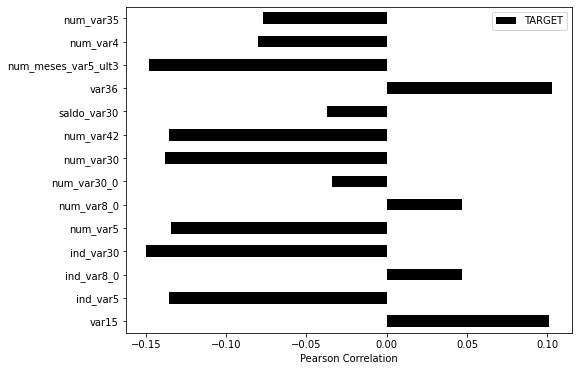

In [12]:
# display correlation to target as barchart
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = pd.DataFrame(d[x_names + [y_name]].corr()[y_name]).iloc[:-1].plot(kind='barh', ax=ax_, colormap='gnuplot')
_ = ax_.set_xlabel('Pearson Correlation')

This plot of Pearson correlation shows that the `num_meses_var5_ult3` payment status features are the most correlated to `TARGET`. The `num_meses_var5_ult3` features are nagetively correlated with `TARGET`. `var36` appears to be the most positively correlated, followed by the `varl15` features. 

It is reasonable to expect a more complex model to reflect many of these findings.

## 3. Train Elastic Net Logistic GLM for Initial Feature Selection 
Elastic net penalized regression is a linear modeling technique that uses L2 regularization and (often) the IRLS optimization approach to be more robust to correlation and outliers than traditional OLS regression methods. It is also able to use L1 regularization to select features without the potentially problematic multiple hypotheses testing found in forward and backward selection methods. Elastic net regression does not produce *t*-statistic and *p*-values like OLS regression methods, but the model coefficients have roughly the same interpretation as the more traditional approach. 

Elastic net regression will serve as the next step beyond Pearson correlation to model `DEFAULT_NEXT_MONTH`. Because of its robustness and interpretability, elastic net regression is often a good choice for a benchmark model from which to construct more complex models.

### 3.1 Elastic Net Forward Step-wise Training

#### Split data into training and validation partitions
Most elastic net approaches require validation for hyperparameter tuning.

#### Train penalized GLM for initial benchmark and feature selection 
The `glm_grid()` function below automatically searches over elastic net hyperparameters to find the best penalized linear model for a dataset. 

In [13]:
iniv=1
d['ID'] = range(iniv, len(d) +iniv)

In [14]:
d.head()
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Data columns (total 16 columns):
var15                  76020 non-null int64
ind_var5               76020 non-null int64
ind_var8_0             76020 non-null int64
ind_var30              76020 non-null int64
num_var5               76020 non-null int64
num_var8_0             76020 non-null int64
num_var30_0            76020 non-null int64
num_var30              76020 non-null int64
num_var42              76020 non-null int64
saldo_var30            76020 non-null float64
var36                  76020 non-null int64
num_meses_var5_ult3    76020 non-null int64
num_var4               76020 non-null int64
num_var35              76020 non-null int64
TARGET                 76020 non-null float64
ID                     76020 non-null int32
dtypes: float64(2), int32(1), int64(13)
memory usage: 9.0 MB


In [15]:
split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(d)) < split_ratio
train = d[split]
valid = d[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 53155, columns = 16
Validation data rows = 22865, columns = 16


In [16]:
# train penalized GLM w/ alpha and lambda grid search
best_glm = model.glm_grid(x_names, y_name, h2o.H2OFrame(train),
                          h2o.H2OFrame(valid), SEED)

# output results
print('Best penalized GLM AUC: %.2f' % 
      best_glm.auc(valid=True))

# print selected coefficients
print('Best penalized GLM coefficients:')
for c_name, c_val in sorted(best_glm.coef().items(), key=operator.itemgetter(1)):
    if abs(c_val) > GLM_SELECTION_THRESHOLD:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))

Best penalized GLM AUC: 0.79
Best penalized GLM coefficients:
Intercept:                -4.021081602601992
ind_var30:                -0.5792961226614448
num_var30:                -0.3652248664794315
num_meses_var5_ult3:      -0.2447379748670939
var36:                    0.0011601477635634194
num_var35:                0.01783660975460644
var15:                    0.03632644721497104
num_var30_0:              0.09107065386706557
num_var8_0:               0.11041342478040213
num_var5:                 0.12110980739544985
num_var4:                 0.17423627493365648
ind_var5:                 0.3439041901574657
ind_var8_0:               0.5544349303172618


The penalized GLM selects the six `PAY_*` repayment status features to predict `p_DEFAULT_NEXT_MONTH`. The coefficient for, say `PAY_0`, can be interpreted as: holding all other features constant, for a 1-unit change in most recent repayment status (`PAY_0`), the odds of a customer defaulting next month (`DEFAULT_NEXT_MONTH`) change by a factor of 1.71 (*e*<sup>0.537</sup>). The penalized GLM has an adequate `AUC` of 0.73, meaning that the probability the penalized GLM ranks a discordant pair of customers (customer 1 `DEFAULT_NEXT_MONTH=0`, customer 2 `DEFAULT_NEXT_MONTH=1`) correctly is 0.73.

### 3.2 Model Details for Model Documentation
It is generally important to document all details of a model in case something goes wrong with the model in the future and someone needs to investigate what happened. 

#### Display best GLM information

In [17]:
best_glm 

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_Key_Frame__upload_95d49cde6bd668181d4d3653269e4584.hex_model_python_1593158546662_1_model_4


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.99, lambda = 1.436E-4 )","nlambda = 100, lambda.max = 0.02885, lambda.min = 1.436E-4, lambda...",14,13,73,Key_Frame__upload_95d49cde6bd668181d4d3653269e4584.hex




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.03633780360814029
RMSE: 0.19062477175891987
LogLoss: 0.14822485950539072
Null degrees of freedom: 53154
Residual degrees of freedom: 53141
Null deviance: 17617.013347821343
Residual deviance: 15757.784814018085
AIC: 15785.784814018085
AUC: 0.7783727239701457
pr_auc: 0.1209476452872773
Gini: 0.5567454479402913

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07537384493779972: 

,,0,1,Error,Rate
0,0,45630.0,5436.0,0.1065,(5436.0/51066.0)
1,1,1093.0,996.0,0.5232,(1093.0/2089.0)
2,Total,46723.0,6432.0,0.1228,(6529.0/53155.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.075374,0.233775,183.0
1,max f2,0.066644,0.352865,197.0
2,max f0point5,0.075374,0.179027,183.0
3,max accuracy,0.999257,0.960719,0.0
4,max precision,0.999257,1.000000,0.0
5,max recall,0.000132,1.000000,399.0
6,max specificity,0.999257,1.000000,0.0
7,max absolute_mcc,0.066644,0.227959,197.0
8,max min_per_class_accuracy,0.044074,0.690969,243.0
9,max mean_per_class_accuracy,0.065841,0.711505,199.0



Gains/Lift Table: Avg response rate:  3.93 %, avg score:  3.93 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010027,2.090588e-01,3.341770,3.341770,0.131332,0.286455,0.131332,0.286455,0.033509,0.033509,234.176967,234.176967
1,,2,0.020017,1.656853e-01,4.504421,3.922003,0.177024,0.183767,0.154135,0.235208,0.044998,0.078506,350.442142,292.200283
2,,3,0.031493,1.398312e-01,4.546763,4.149663,0.178689,0.151075,0.163082,0.204550,0.052178,0.130685,354.676330,314.966345
3,,4,0.040354,1.272304e-01,3.781663,4.068858,0.148620,0.131709,0.159907,0.188556,0.033509,0.164193,278.166292,306.885774
4,,5,0.050569,1.156125e-01,3.842552,4.023142,0.151013,0.119551,0.158110,0.174616,0.039253,0.203447,284.255157,302.314188
5,,6,0.101853,8.333176e-02,3.901720,3.962005,0.153338,0.096429,0.155707,0.135248,0.200096,0.403542,290.172012,296.200488
6,,7,0.157107,6.585349e-02,2.893665,3.586276,0.113721,0.072289,0.140941,0.113106,0.159885,0.563427,189.366468,258.627560
7,,8,0.209745,5.945833e-02,0.800278,2.887090,0.031451,0.061336,0.113463,0.100113,0.042125,0.605553,-19.972243,188.708980
8,,9,0.300009,5.268573e-02,0.604575,2.200346,0.023760,0.057242,0.086474,0.087214,0.054572,0.660124,-39.542485,120.034588
9,,10,0.400000,3.000221e-02,1.153771,1.938727,0.045343,0.038800,0.076192,0.075112,0.115366,0.775491,15.377057,93.872666




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.0369291058350174
RMSE: 0.1921694716520223
LogLoss: 0.1491334013790515
Null degrees of freedom: 22864
Residual degrees of freedom: 22851
Null deviance: 7708.509427062608
Residual deviance: 6819.870445064025
AIC: 6847.870445064025
AUC: 0.787306775449523
pr_auc: 0.12914604671198318
Gini: 0.574613550899046

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07795948797027566: 

,,0,1,Error,Rate
0,0,19738.0,2208.0,0.1006,(2208.0/21946.0)
1,1,488.0,431.0,0.531,(488.0/919.0)
2,Total,20226.0,2639.0,0.1179,(2696.0/22865.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.077959,0.242271,173.0
1,max f2,0.065844,0.361528,192.0
2,max f0point5,0.101555,0.191923,145.0
3,max accuracy,0.636075,0.959764,0.0
4,max precision,0.440086,0.200000,7.0
5,max recall,0.001554,1.000000,394.0
6,max specificity,0.636075,0.999954,0.0
7,max absolute_mcc,0.066051,0.234465,191.0
8,max min_per_class_accuracy,0.045678,0.696573,232.0
9,max mean_per_class_accuracy,0.063081,0.719779,196.0



Gains/Lift Table: Avg response rate:  4.02 %, avg score:  3.94 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010365,2.128012e-01,3.989247,3.989247,0.160338,0.282093,0.160338,0.282093,0.041349,0.041349,298.924716,298.924716
1,,2,0.020818,1.631383e-01,4.476373,4.233833,0.179916,0.182130,0.170168,0.231901,0.046790,0.088139,347.637281,323.383336
2,,3,0.031271,1.398312e-01,4.059966,4.175715,0.163180,0.148425,0.167832,0.203998,0.042437,0.130577,305.996604,317.571547
3,,4,0.040805,1.272304e-01,4.222804,4.186718,0.169725,0.131696,0.168274,0.187104,0.040261,0.170838,322.280401,318.671794
4,,5,0.052438,1.156125e-01,4.863819,4.336934,0.195489,0.119794,0.174312,0.172171,0.056583,0.227421,386.381896,333.693384
5,,6,0.100022,8.441961e-02,3.818944,4.090509,0.153493,0.097992,0.164408,0.136882,0.181719,0.409140,281.894382,309.050921
6,,7,0.159239,6.585349e-02,2.793062,3.608020,0.112260,0.072804,0.145015,0.113053,0.165397,0.574538,179.306227,260.802001
7,,8,0.210321,5.945833e-02,0.873367,2.943833,0.035103,0.061349,0.118320,0.100495,0.044614,0.619151,-12.663314,194.383310
8,,9,0.300022,5.313963e-02,0.521625,2.219642,0.020965,0.057318,0.089213,0.087586,0.046790,0.665941,-47.837489,121.964234
9,,10,0.400000,3.003084e-02,1.218983,1.969532,0.048994,0.039064,0.079160,0.075458,0.121872,0.787813,21.898256,96.953210




Scoring History: 

,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
0,,2020-06-26 04:02:37,0.000 sec,1,.29E-1,1,0.331427,0.337131
1,,2020-06-26 04:02:37,0.023 sec,3,.26E-1,2,0.327890,0.333306
2,,2020-06-26 04:02:37,0.040 sec,5,.24E-1,3,0.324885,0.330025
3,,2020-06-26 04:02:37,0.063 sec,7,.22E-1,3,0.322460,0.327362
4,,2020-06-26 04:02:37,0.082 sec,9,.2E-1,3,0.320496,0.325192
5,,2020-06-26 04:02:37,0.103 sec,11,.18E-1,4,0.317420,0.321874
6,,2020-06-26 04:02:37,0.122 sec,13,.17E-1,4,0.314755,0.318991
7,,2020-06-26 04:02:37,0.144 sec,15,.15E-1,5,0.312563,0.316607
8,,2020-06-26 04:02:37,0.164 sec,17,.14E-1,5,0.310579,0.314435
9,,2020-06-26 04:02:37,0.185 sec,19,.12E-1,5,0.308952,0.312644



See the whole table with table.as_data_frame()


#### Plot penalized GLM coefficient regularization path
One kind of information someone might be interested in for elastic net GLM is the regularization path for the model coefficients. The plot below shows how the training process treated each `PAY_*` feature during the training process.

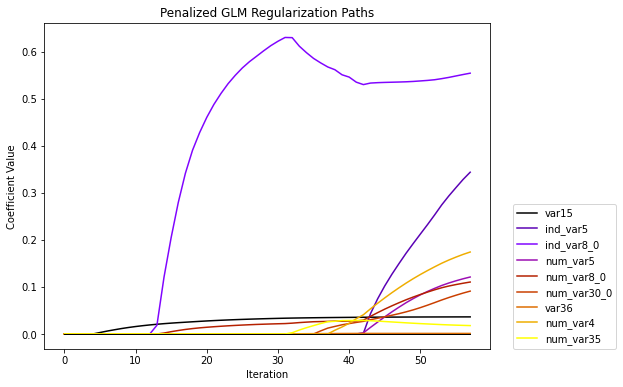

In [18]:
# collect regularization paths from dict in DataFrame
reg_path_dict = best_glm.getGLMRegularizationPath(best_glm)
reg_path_frame = pd.DataFrame(columns=reg_path_dict['coefficients'][0].keys())
for i in range(0, len(reg_path_dict['coefficients'])): 
    reg_path_frame = reg_path_frame.append(reg_path_dict['coefficients'][i], 
                                           ignore_index=True)

    
# establish benchmark feature selection: glm_selected 
glm_selected = list(reg_path_frame.iloc[-1, :][reg_path_frame.iloc[-1, :] > GLM_SELECTION_THRESHOLD].index)

# plot regularization paths
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = reg_path_frame[glm_selected].plot(kind='line', ax=ax_, title='Penalized GLM Regularization Paths',
                                      colormap='gnuplot')
_ = ax_.set_xlabel('Iteration')
_ = ax_.set_ylabel('Coefficient Value')
_ = ax_.axhline(c='k', lw=1, xmin=0.045, xmax=0.955)
_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

### 3.3 Compare Global Model Weights Against Alternative Model

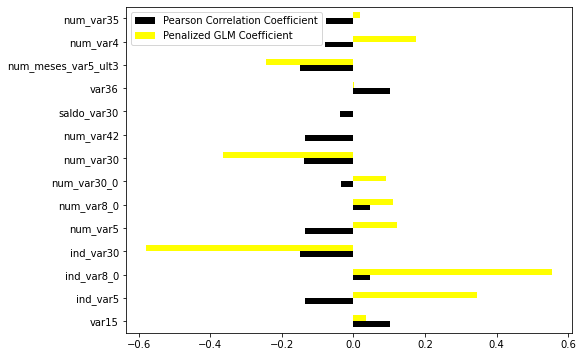

In [19]:
# collect Pearson correlation and GLM coefficients into same DataFrame
glm_selected_coef = pd.DataFrame.from_dict(best_glm.coef(), orient='index', columns=['Penalized GLM Coefficient'])
corr_glm = pd.concat([corr, glm_selected_coef.iloc[1:]], axis=1)

# plot
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = corr_glm.plot(kind='barh', ax=ax_, colormap='gnuplot')

As compared to Pearson correlation, the penalized GLM does select the 6 features that are most positively correlated to `DEFAULT_NEXT_MONTH`. However, it does not select any of the negatively correlated features and it gives extremely high weight to `PAY_0` and weighs `PAY_5` out of order in time.

NameError: name 'shap_contribs_matrix' is not defined

### 3.4 Partial Dependence and ICE for Model Documentation
Plots of partial dependence display the estimated average behavior of a predictive model across the domain of an input feature. ICE plots show how certain individuals behave under a model. Pairing partial dependence and ICE together provides a nice portrait of the behavior of a feature under a model on average and for some individuals.

#### Calculate partial dependence for each feature in best GLM

#### Find some percentiles of yhat in the validation data
ICE can be plotted for just one or many individuals. Since no particular individual is interesting, yet, under the penalized GLM, individuals at deciles of `p_DEFAULT_NEXT_MONTH` are selected for ICE.

In [20]:
#d['ID'] = np.arange(len(d))
#iniv=1
#d['ID'] = range(iniv, len(d) +iniv)

#d.set_index('ID')
#d=d.drop(['level_0', 'index'], axis=1)

In [21]:
d.head()
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Data columns (total 16 columns):
var15                  76020 non-null int64
ind_var5               76020 non-null int64
ind_var8_0             76020 non-null int64
ind_var30              76020 non-null int64
num_var5               76020 non-null int64
num_var8_0             76020 non-null int64
num_var30_0            76020 non-null int64
num_var30              76020 non-null int64
num_var42              76020 non-null int64
saldo_var30            76020 non-null float64
var36                  76020 non-null int64
num_meses_var5_ult3    76020 non-null int64
num_var4               76020 non-null int64
num_var35              76020 non-null int64
TARGET                 76020 non-null float64
ID                     76020 non-null int32
dtypes: float64(2), int32(1), int64(13)
memory usage: 9.0 MB


In [22]:
# init dict to hold partial dependence and ICE values
# for each feature
# for glm
glm_pd_ice_dict = {}

# calculate partial dependence for each selected feature
for xs in glm_selected: 
    glm_pd_ice_dict[xs] = explain.pd_ice(xs, valid, best_glm)

In [23]:
# merge GLM predictions onto test data
glm_yhat_valid = pd.concat([valid.reset_index(drop=True),
                            best_glm.predict(h2o.H2OFrame(valid))['p1'].as_data_frame()],
                           axis=1)

# rename yhat column
glm_yhat_valid = glm_yhat_valid.rename(columns={'p1':'p_TARGET'})

# find percentiles of predictions
glm_percentile_dict = explain.get_percentile_dict('p_TARGET', glm_yhat_valid, 'ID')

# display percentiles dictionary
# key=percentile, val=row_id
glm_percentile_dict

{0: 47161,
 99: 71498,
 10: 75538,
 20: 62189,
 30: 35466,
 40: 1816,
 50: 51392,
 60: 42654,
 70: 25952,
 80: 968,
 90: 10922}

#### Calculate ICE curve values

In [24]:
# loop through selected features
for xs in glm_selected: 

    # collect bins used in partial dependence
    bins = list(glm_pd_ice_dict[xs][xs])
    
    # calculate ICE at percentiles 
    # using partial dependence bins
    # for each selected feature
    for i in sorted(glm_percentile_dict.keys()):
        col_name = 'Percentile_' + str(i)
        glm_pd_ice_dict[xs][col_name] = explain.pd_ice(xs, # x_names used here b/c all features have small coef in GLM
                                                       valid[valid['ID'] == int(glm_percentile_dict[i])][x_names], 
                                                       best_glm, 
                                                       bins=bins)['partial_dependence']
       

#### Assess partial dependence and ICE for each feature in best GLM
In addition to displaying partial dependence and ICE plots below, a histogram of the feature of interest is also displayed. The histogram helps uncover issues related to data sparsity, i.e., in the areas of an input feature's domain where there is little or no training data, the model's predictions are generally less trustworthy. The histograms below also include an overlay of the average value of `DEFAULT_NEXT_MONTH`. This overlay gives some understanding of what partial dependence and ICE curves should look like.

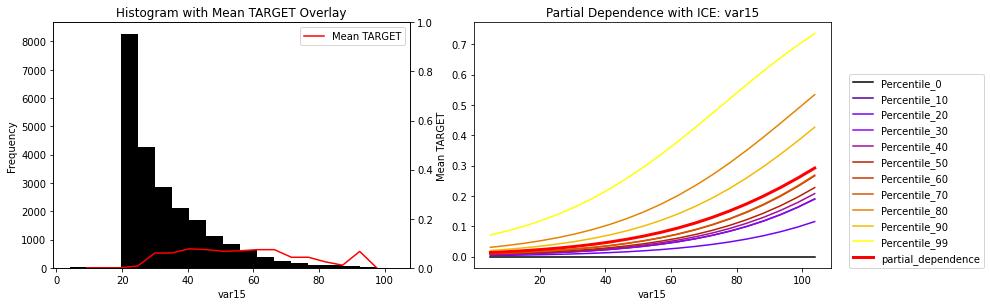

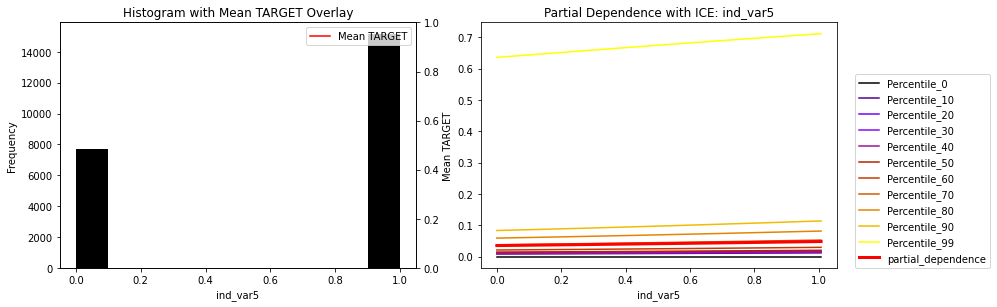

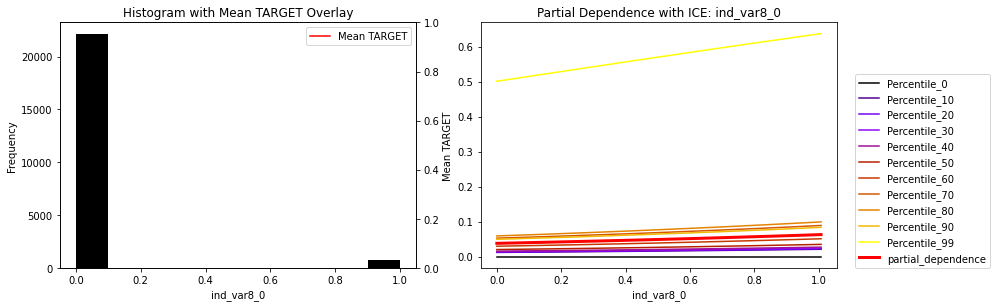

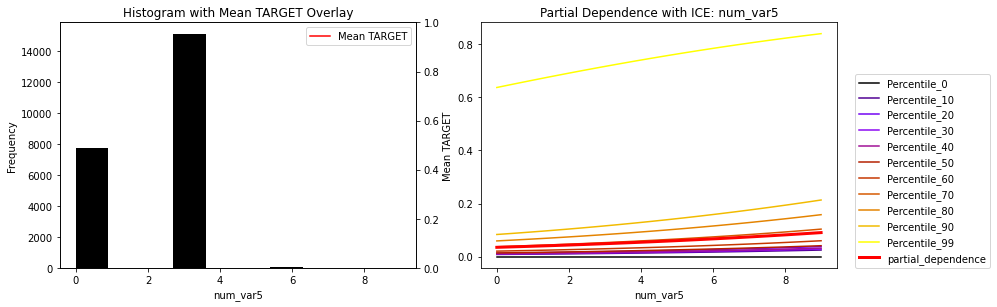

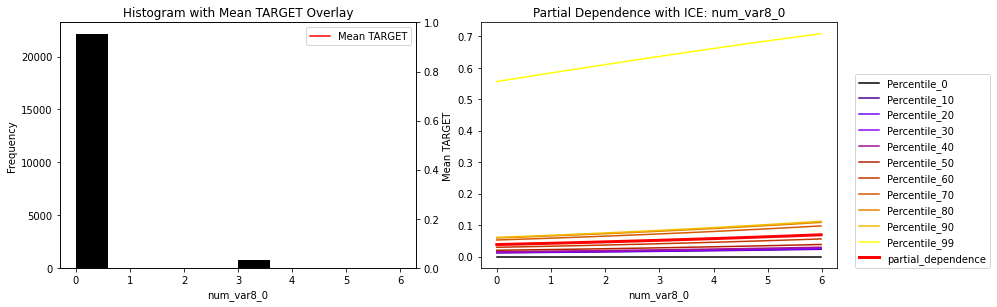

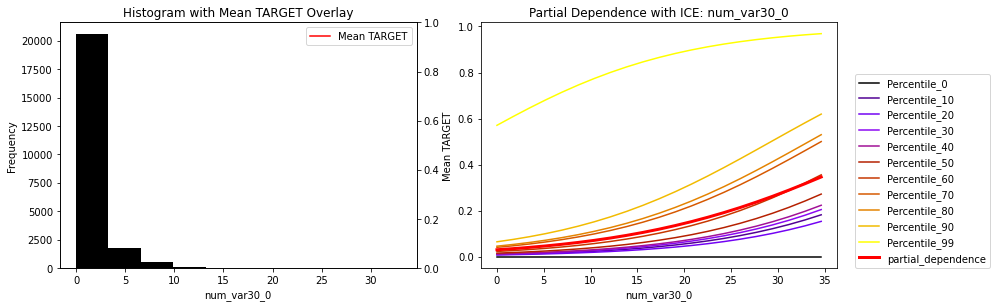

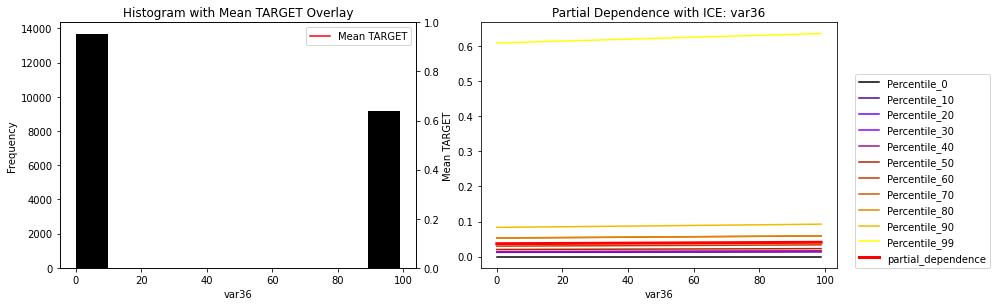

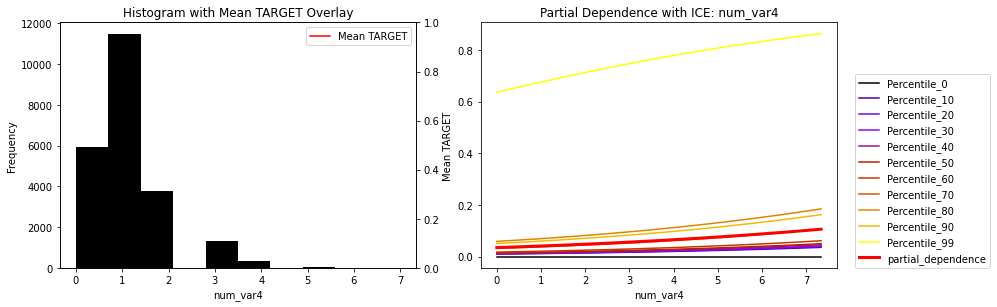

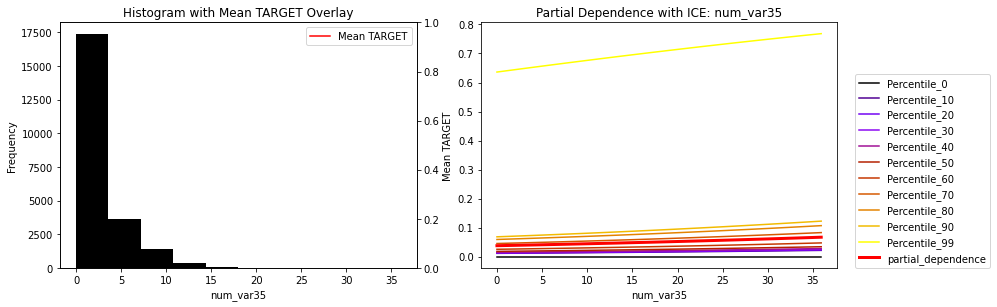

In [25]:
for xs in glm_selected: 
    explain.hist_mean_pd_ice_plot(xs, y_name, valid, glm_pd_ice_dict)

The plots above show the expected logistic behavior for each input feature, with `PAY_0` showing the steepest partial dependence and ICE curves. Aside from the high-degree of importance placed on `PAY_0`, these plots are aligned with the small Pearson correlations for the remaining `PAY_*` features. Histograms do display some data sparsity problems for customers with late payments and mean `DEFAULT_NEXT_MONTH` overlays do show some nonlinear swings in average `DEFAULT_NEXT_MONTH` values, but the logistic form of the model prevents it from overfitting noise in the sparse areas. The monotonic logistic model also does not allow for fitting to the potentially non-monotonic average behavior of  `DEFAULT_NEXT_MONTH`. Below, these plots will allow for the comparison of the penalized GLM to a monotonic GBM model on a per-feature basis.

## 4. Train Monotonic GBM with Forward Feature Selection
The next step in complexity from the penalized GLM will be a monotonically constrained GBM model. The GBM model can fit the data using arbitrarily complex stair-step patterns, as opposed to being locked into the logistic function form. The goal is to compare the behavior of the monotonic GBM to the penalized GLM and Pearson correlation coefficients to make sure we trust and understand what the monotonic GBM is doing. 

### 4.1 Forward Step-wise Training
The monotonic GBM will start with the 6 `PAY_*` features selected by the GLM, then try adding in the next most correlated feature to the model. Monotone constraints for each feature are also set by the sign of the Pearson correlation between an input feature and `DEFAULT_NEXT_MONTH`. Each new set of training features is run through a random grid search to make sure a somewhat stable and accurate GBM is trained during each forward selection step. 

In [26]:
# initialize data structures needed to compare correlation coefficients,
# penalized glm coefficients, and MGBM Shapley values
# as features are added into the MGBM
abs_corr = corr.copy(deep=True)
abs_corr['Pearson Correlation Coefficient'] = corr['Pearson Correlation Coefficient'].abs()

# create a list of features to add into MGBM
# list is ordered by correlation between X_j and y
next_list = [name for name in list(abs_corr.sort_values(by='Pearson Correlation Coefficient',
                                                        ascending=False).index) if name not in glm_selected]

# create a DataFrame to store new MGBM SHAP values
# for comparison to correlation and penalized glm coefficients
abs_corr_glm_mgbm_shap = corr_glm.copy(deep=True).abs()
abs_corr_glm_mgbm_shap.columns = ['Absolute ' + name for name in abs_corr_glm_mgbm_shap.columns]
abs_corr_glm_mgbm_shap['Monotonic GBM Mean SHAP Value'] = 0

# start local timer
tic = time.time()

# forward stepwise MGBM training
mgbm_train_results = model.gbm_forward_select_train(glm_selected, 
                                                    y_name, 
                                                    train, 
                                                    valid, 
                                                    SEED, 
                                                    next_list,
                                                    abs_corr_glm_mgbm_shap, 
                                                    'Monotonic GBM Mean SHAP Value',
                                                    monotone=True)

mgbm_models = mgbm_train_results['MODELS']
corr_glm_mgbm_shap_coefs = mgbm_train_results['GLOBAL_COEFS']
mgbm_shap = mgbm_train_results['LOCAL_COEFS']

# end local timer
toc = time.time()-tic
print('Task completed in %.2f s.' % (toc))

# 2 threads  - 695 s
# 4 threads  - 691 s
# 8 threads  - 692 s
# 24 threads - 713 s

Starting grid search 1/6 ...
Input features = ['var15', 'ind_var5', 'ind_var8_0', 'num_var5', 'num_var8_0', 'num_var30_0', 'var36', 'num_var4', 'num_var35']
Monotone constraints = {'var15': 1, 'ind_var5': -1, 'ind_var8_0': 1, 'num_var5': -1, 'num_var8_0': 1, 'num_var30_0': -1, 'var36': 1, 'num_var4': -1, 'num_var35': -1}
Completed grid search 1/6 with AUC: 0.81 ...
--------------------------------------------------------------------------------
Starting grid search 2/6 ...
Input features = ['var15', 'ind_var5', 'ind_var8_0', 'num_var5', 'num_var8_0', 'num_var30_0', 'var36', 'num_var4', 'num_var35', 'ind_var30']
Monotone constraints = {'var15': 1, 'ind_var5': -1, 'ind_var8_0': 1, 'num_var5': -1, 'num_var8_0': 1, 'num_var30_0': -1, 'var36': 1, 'num_var4': -1, 'num_var35': -1, 'ind_var30': -1}
Completed grid search 2/6 with AUC: 0.81 ...
--------------------------------------------------------------------------------
Starting grid search 3/6 ...
Input features = ['var15', 'ind_var5', 'ind

### 4.2 Compare Global Model Weights for Alternative Models
Shapley values, or the mean contribution of a feature beyond the average prediction, allow us to compare how the monotonic GBM weighs features as compared to the penalized GLM and the Pearson correlation coefficients. For each model, the similarities are somewhat striking given that no values were scaled. Also note that the first monotonic GBM model, trained on only the GLM features, is more accurate than the penalized GLM. This indicates the ability of the monotonic GBM to fit nonlinear stair-step patterns is likely useful and representative of the training data.

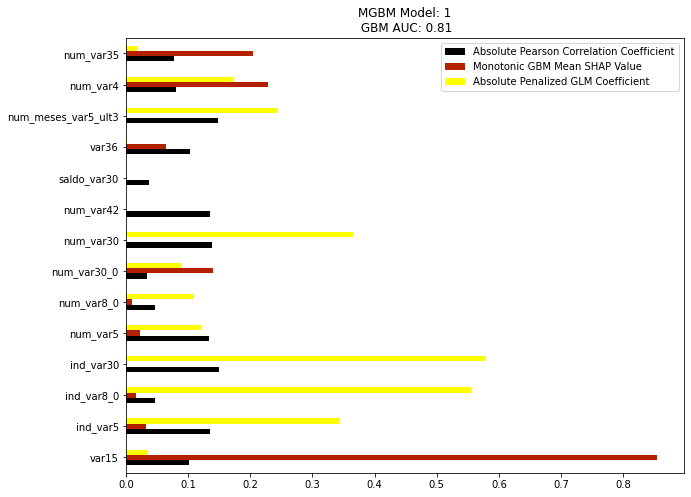

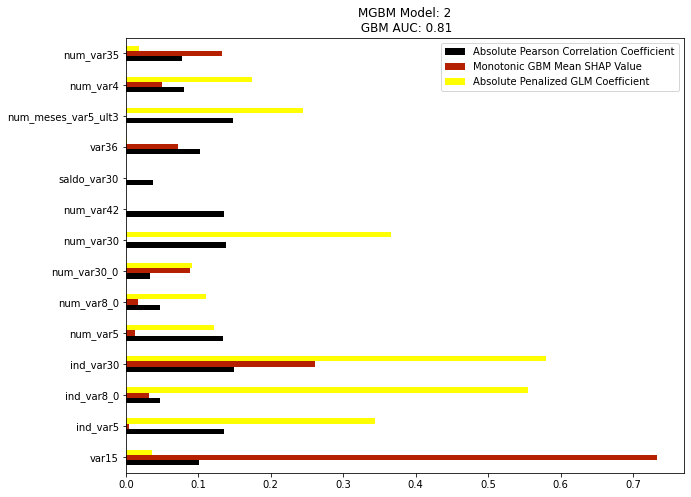

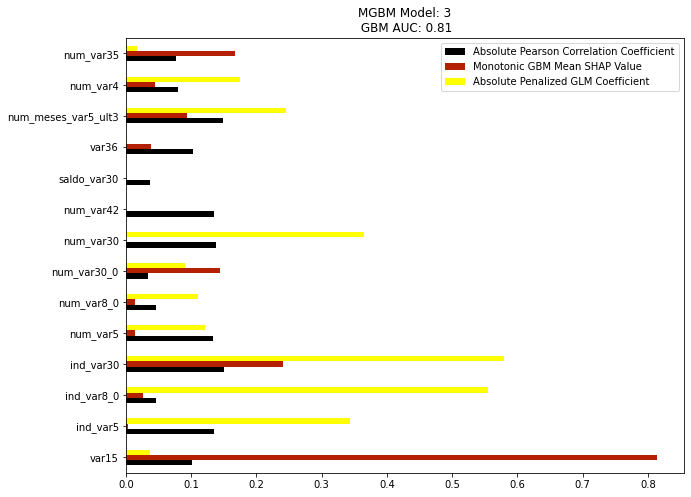

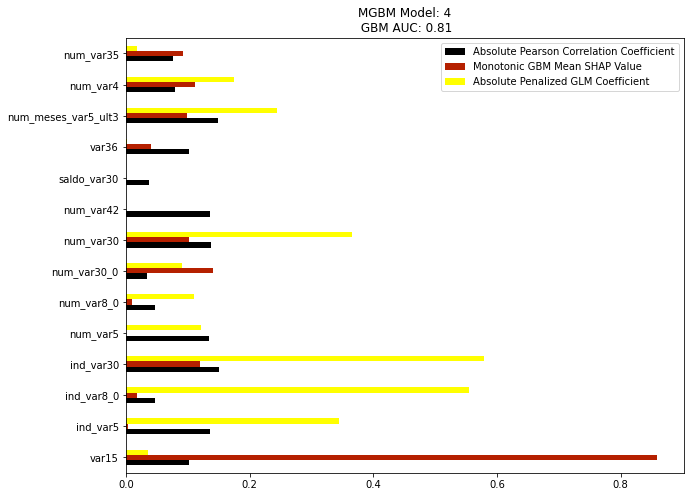

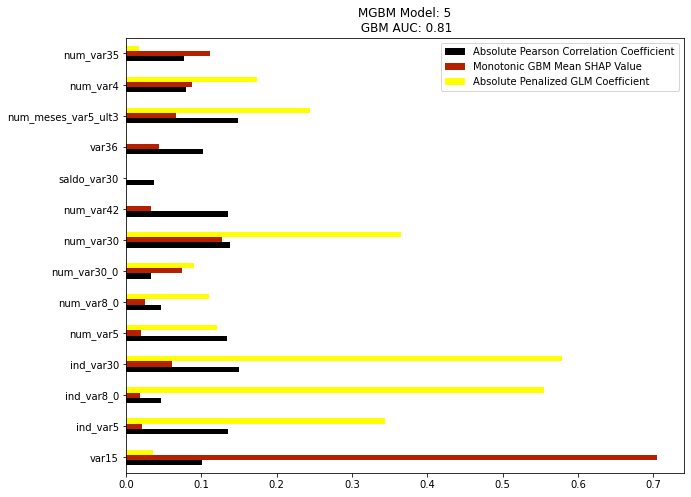

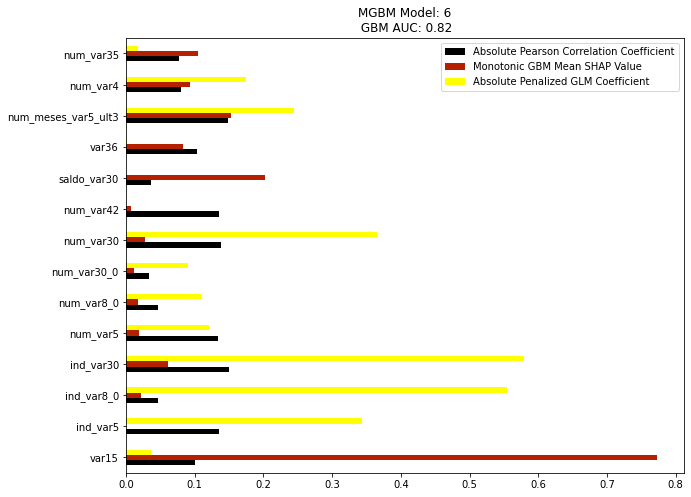

In [27]:
explain.plot_coefs(corr_glm_mgbm_shap_coefs,
                   mgbm_models, 
                   'MGBM',
                   ['Absolute Pearson Correlation Coefficient',
                    'Monotonic GBM Mean SHAP Value',
                    'Absolute Penalized GLM Coefficient'])

###  4.3 Perform Cross-validated Ranking to Select Best MGBM Against Alternative Models
For small data, selecting a best model based on a single value in a validation set can lead to silly results. Here, a combination of ranking models across many metrics and many folds is used to ensure that the simplest and most accurate model is selected.

In [28]:
# autoph cv_model_rank_select function
# requires models to have model_id 
best_glm.model_id = 'best_glm'
compare_model_ids = ['best_glm'] # list of model_ids

# start local timer
tic = time.time()

# perform CV rank model selection
mgbm_rank_results = evaluate.cv_model_rank_select(valid,
                                                  SEED,
                                                  mgbm_train_results,
                                                  'mgbm',
                                                  compare_model_ids)

best_mgbm = mgbm_rank_results['BEST_MODEL']
best_mgbm_shap = mgbm_rank_results['BEST_LOCAL_COEFS']
mgbm_selected_coefs = mgbm_rank_results['BEST_GLOBAL_COEFS']
best_mgbm_eval = mgbm_rank_results['METRICS']


# end local timer
toc = time.time()-tic
print('Task completed in %.2f s.' % (toc))

Evaluated model 1/6 with rank: 1.30* ...
Evaluated model 2/6 with rank: 1.22* ...
Evaluated model 3/6 with rank: 1.18* ...
Evaluated model 4/6 with rank: 1.26 ...
Evaluated model 5/6 with rank: 1.16* ...
Evaluated model 6/6 with rank: 1.06* ...
Done.
Task completed in 134.01 s.


### 4.4 Model Details for Model Documentation

#### Inspect best MGBM 

In [29]:
best_mgbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  mgbm6


Model Summary: 

,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,201.0,201.0,22026.0,0.0,8.0,1.587065,1.0,18.0,3.825871




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.03527097574752541
RMSE: 0.1878056861426869
LogLoss: 0.13957076174320626
Mean Per-Class Error: 0.25545597633466466
AUC: 0.813513508091735
pr_auc: 0.1451144812813689
Gini: 0.6270270161834699

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11007087202022722: 

,,0,1,Error,Rate
0,0,46065.0,5001.0,0.0979,(5001.0/51066.0)
1,1,1063.0,1026.0,0.5089,(1063.0/2089.0)
2,Total,47128.0,6027.0,0.1141,(6064.0/53155.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.110071,0.252834,112.0
1,max f2,0.052997,0.367647,192.0
2,max f0point5,0.144074,0.198521,81.0
3,max accuracy,0.585063,0.960700,1.0
4,max precision,0.585063,0.500000,1.0
5,max recall,0.001736,1.000000,397.0
6,max specificity,0.644090,0.999980,0.0
7,max absolute_mcc,0.092526,0.243631,136.0
8,max min_per_class_accuracy,0.035138,0.740546,252.0
9,max mean_per_class_accuracy,0.040105,0.744544,233.0



Gains/Lift Table: Avg response rate:  3.93 %, avg score:  3.93 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.025661,0.192758,4.701017,4.701017,0.184751,0.220051,0.184751,0.220051,0.120632,0.120632,370.101734,370.101734
1,,2,0.034070,0.191631,4.098554,4.552314,0.161074,0.191750,0.178907,0.213066,0.034466,0.155098,309.855395,355.231434
2,,3,0.045584,0.186289,4.282442,4.484150,0.168301,0.186541,0.176228,0.206366,0.049306,0.204404,328.244195,348.415012
3,,4,0.053259,0.184414,4.303231,4.458076,0.169118,0.185112,0.175203,0.203303,0.033030,0.237434,330.323051,345.807622
4,,5,0.100047,0.135278,4.368756,4.416305,0.171693,0.169163,0.173561,0.187337,0.204404,0.441838,336.875583,341.630491
5,,6,0.150089,0.058674,2.592348,3.808167,0.101880,0.092341,0.149662,0.155664,0.129727,0.571565,159.234821,280.816693
6,,7,0.202069,0.044692,1.832643,3.299986,0.072023,0.048742,0.129690,0.128159,0.095261,0.666826,83.264301,229.998589
7,,8,0.304656,0.032936,0.951920,2.509322,0.037411,0.038188,0.098617,0.097863,0.097654,0.764481,-4.808022,150.932240
8,,9,0.407393,0.027031,0.792104,2.076271,0.031130,0.029686,0.081598,0.080670,0.081379,0.845859,-20.789560,107.627103
9,,10,0.500047,0.016000,0.542486,1.792077,0.021320,0.020787,0.070429,0.069575,0.050263,0.896123,-45.751374,79.207652




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.0359549128225145
RMSE: 0.18961780724002295
LogLoss: 0.14071231355448857
Mean Per-Class Error: 0.2496818037983628
AUC: 0.8227920108978541
pr_auc: 0.14886103481477986
Gini: 0.6455840217957083

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11796957302676461: 

,,0,1,Error,Rate
0,0,19841.0,2105.0,0.0959,(2105.0/21946.0)
1,1,479.0,440.0,0.5212,(479.0/919.0)
2,Total,20320.0,2545.0,0.113,(2584.0/22865.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.117970,0.254042,87.0
1,max f2,0.044980,0.378197,196.0
2,max f0point5,0.163728,0.202543,55.0
3,max accuracy,0.656236,0.959851,0.0
4,max precision,0.656236,1.000000,0.0
5,max recall,0.004116,1.000000,387.0
6,max specificity,0.656236,1.000000,0.0
7,max absolute_mcc,0.091268,0.246971,121.0
8,max min_per_class_accuracy,0.035486,0.746464,234.0
9,max mean_per_class_accuracy,0.037650,0.750318,224.0



Gains/Lift Table: Avg response rate:  4.02 %, avg score:  4.00 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.025410,0.192758,4.325148,4.325148,0.173838,0.225247,0.173838,0.225247,0.109902,0.109902,332.514763,332.514763
1,,2,0.035557,0.191631,4.396950,4.345637,0.176724,0.191778,0.174662,0.215696,0.044614,0.154516,339.695040,334.563747
2,,3,0.041898,0.186837,5.147649,4.467028,0.206897,0.186837,0.179541,0.211328,0.032644,0.187160,414.764924,346.702756
3,,4,0.052876,0.185752,4.460612,4.465696,0.179283,0.186078,0.179487,0.206086,0.048966,0.236126,346.061239,346.569571
4,,5,0.102777,0.146823,4.208500,4.340819,0.169150,0.171286,0.174468,0.189189,0.210011,0.446137,320.850027,334.081911
5,,6,0.150842,0.060876,2.626129,3.794445,0.105551,0.097056,0.152508,0.159832,0.126224,0.572361,162.612861,279.444484
6,,7,0.202449,0.044692,2.129585,3.370048,0.085593,0.049156,0.135450,0.131619,0.109902,0.682263,112.958540,237.004775
7,,8,0.302821,0.032936,0.943175,2.565647,0.037908,0.038243,0.103120,0.100669,0.094668,0.776931,-5.682505,156.564667
8,,9,0.406429,0.027031,0.819191,2.120435,0.032925,0.029707,0.085225,0.082579,0.084875,0.861806,-18.080888,112.043488
9,,10,0.500022,0.015605,0.476679,1.812761,0.019159,0.020687,0.072859,0.070994,0.044614,0.906420,-52.332127,81.276076




Scoring History: 

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-06-26 04:09:57,1 min 11.359 sec,0.0,0.194308,0.165714,0.500000,0.000000,1.000000,0.960700,0.196412,0.168566,0.500000,0.000000,1.000000,0.959808
1,,2020-06-26 04:09:58,1 min 11.405 sec,1.0,0.193794,0.163153,0.731185,0.110156,2.206604,0.259317,0.195845,0.165729,0.742837,0.130736,2.257440,0.260748
2,,2020-06-26 04:09:58,1 min 11.444 sec,2.0,0.192703,0.158510,0.770921,0.130793,4.352995,0.119387,0.194726,0.160931,0.781568,0.139359,4.321258,0.104527
3,,2020-06-26 04:09:58,1 min 11.488 sec,3.0,0.192232,0.156508,0.802630,0.137527,4.309025,0.119086,0.194229,0.158829,0.811062,0.145344,4.355131,0.104527
4,,2020-06-26 04:09:58,1 min 11.533 sec,4.0,0.191903,0.155312,0.795317,0.134712,4.299187,0.119217,0.193878,0.157525,0.805973,0.141782,4.319497,0.104527
5,,2020-06-26 04:09:58,1 min 11.576 sec,5.0,0.191171,0.152825,0.800826,0.136037,4.276080,0.119293,0.193133,0.154992,0.810252,0.140845,4.270175,0.123639
6,,2020-06-26 04:09:58,1 min 11.622 sec,6.0,0.190616,0.150969,0.805225,0.137780,4.299187,0.104995,0.192555,0.153067,0.814157,0.144310,4.319497,0.104527
7,,2020-06-26 04:09:58,1 min 11.670 sec,7.0,0.190388,0.150099,0.799538,0.136988,4.361433,0.104826,0.192307,0.152122,0.809124,0.144066,4.419675,0.101815
8,,2020-06-26 04:09:58,1 min 11.730 sec,8.0,0.189943,0.148690,0.803696,0.137709,4.353020,0.104807,0.191851,0.150675,0.811819,0.143518,4.398603,0.101684
9,,2020-06-26 04:09:58,1 min 11.795 sec,9.0,0.189580,0.147566,0.803508,0.136675,4.334013,0.104694,0.191482,0.149536,0.811387,0.141415,4.365363,0.101684



See the whole table with table.as_data_frame()

Variable Importances: 

,variable,relative_importance,scaled_importance,percentage
0,var15,207.965546,1.000000,0.417259
1,num_var35,82.134987,0.394945,0.164794
2,num_var4,56.169003,0.270088,0.112697
3,ind_var30,48.198612,0.231762,0.096705
4,saldo_var30,44.185040,0.212463,0.088652
5,num_meses_var5_ult3,25.748129,0.123810,0.051661
6,num_var30,17.097200,0.082212,0.034304
7,ind_var8_0,6.217064,0.029895,0.012474
8,num_var8_0,5.852617,0.028142,0.011743
9,var36,2.147550,0.010326,0.004309


#### Assess best MGBM ranking

In [30]:
best_mgbm_eval

,Fold,Metric,best_glm Value,mgbm6 Value,best_glm Rank,mgbm6 Rank
0,0,F1,0.249292,0.261866,2.0,1.0
1,0,accuracy,0.959371,0.959152,1.0,2.0
2,0,auc,0.787971,0.819844,2.0,1.0
3,0,logloss,0.150245,0.141873,2.0,1.0
4,0,mcc,0.234284,0.253277,2.0,1.0
5,1,F1,0.258953,0.272265,2.0,1.0
6,1,accuracy,0.957282,0.957713,2.0,1.0
7,1,auc,0.790627,0.830596,2.0,1.0
8,1,logloss,0.155570,0.145097,2.0,1.0
9,1,mcc,0.244898,0.263200,2.0,1.0


#### Print mean rank for each model

In [32]:
print('Best GLM mean rank:', best_mgbm_eval['best_glm Rank'].mean())
print('Best MGBM mean rank:', best_mgbm_eval['mgbm6 Rank'].mean())

Best GLM mean rank: 1.94
Best MGBM mean rank: 1.06


### 4.5 Partial Dependence and ICE for Model Documentation

#### Calculate partial dependence for each feature in best MGBM

In [33]:
# init dict to hold partial dependence and ICE values
# for each feature
# for mgbm
mgbm_pd_ice_dict = {}

# establish mgbm selected features
mgbm_selected = list(mgbm_selected_coefs[mgbm_selected_coefs['Monotonic GBM Mean SHAP Value'] != 0].index)

# calculate partial dependence for each selected feature
for xs in mgbm_selected: 
    mgbm_pd_ice_dict[xs] = explain.pd_ice(xs, valid, best_mgbm)

#### Find some percentiles of yhat in the validation data

In [34]:
# merge MGBM predictions onto test data
mgbm_yhat_valid = pd.concat([valid.reset_index(drop=True),
                             best_mgbm.predict(h2o.H2OFrame(valid))['p1'].as_data_frame()],
                            axis=1)

# rename yhat column
mgbm_yhat_valid = mgbm_yhat_valid.rename(columns={'p1':'p_TARGET'})

# find percentiles of predictions
mgbm_percentile_dict = explain.get_percentile_dict('p_TARGET', mgbm_yhat_valid, 'ID')

# display percentiles dictionary
# key=percentile, val=row_id
mgbm_percentile_dict

{0: 25392,
 99: 17012,
 10: 75134,
 20: 45948,
 30: 7073,
 40: 66738,
 50: 44850,
 60: 28044,
 70: 6186,
 80: 71565,
 90: 49978}

#### Calculate ICE curve values

In [35]:
# loop through selected features
for xs in mgbm_selected: 

    # collect bins used in partial dependence
    bins = list(mgbm_pd_ice_dict[xs][xs])
    
    # calculate ICE at percentiles 
    # using partial dependence bins
    # for each selected feature
    for i in sorted(mgbm_percentile_dict.keys()):
        col_name = 'Percentile_' + str(i)
        mgbm_pd_ice_dict[xs][col_name] = explain.pd_ice(xs, 
                                                        valid[valid['ID'] == int(mgbm_percentile_dict[i])][mgbm_selected], 
                                                        best_mgbm, 
                                                        bins=bins)['partial_dependence']
       

#### Assess partial dependence and ICE for each feature in best MGBM
The partial dependence and ICE curves for the monotonic GBM show that it picks up on discrete jumps in the probabilities of default, say at `PAY_0 >= 2`. Given the increased accuracy (AUC = 0.77) of the monotonic GBM model, some of these jumps are likely to be real. Like the penalized GLM, it's monotone constraints help it to remain stable in areas of sparse training data. The real question is: would a lending domain expert find the discrete stair-step form of the monotonic GBM, as represented by partial dependence and ICE, to be more realistic than the smooth logistic form of the penalized GLM. At least with interpretable models, as opposed to traditional black-box machine learning, we can ask questions like this!

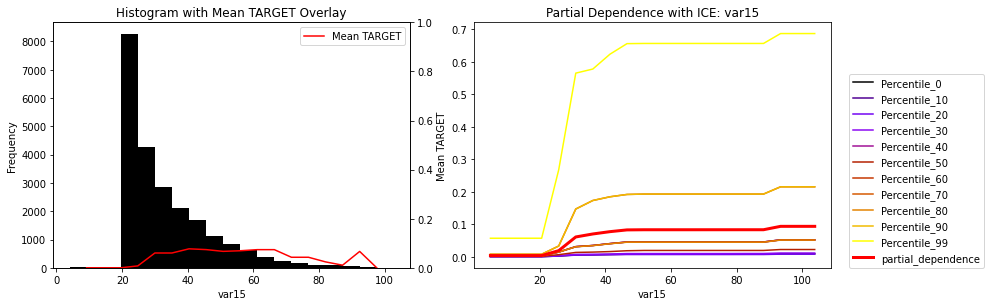

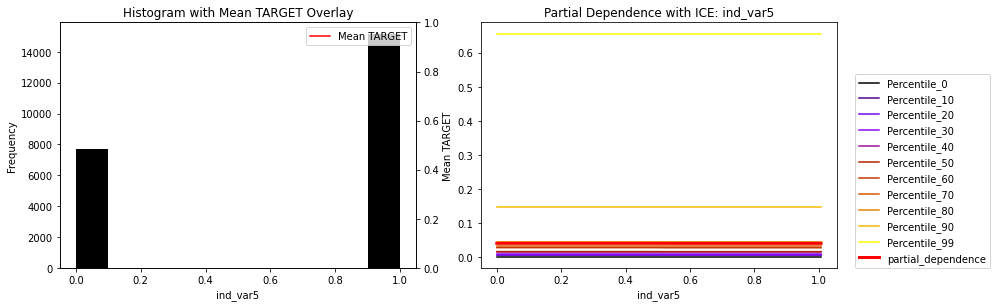

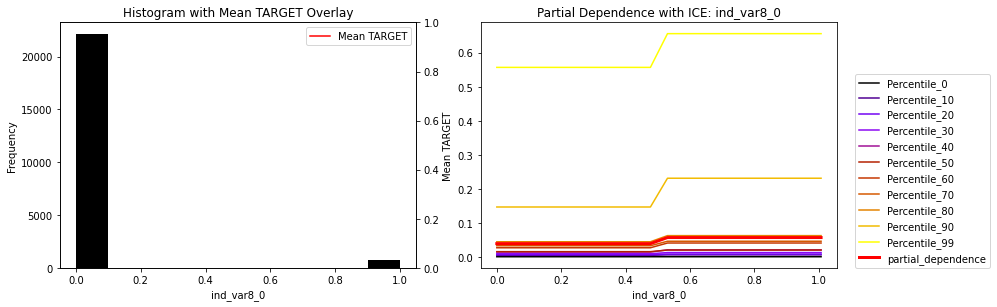

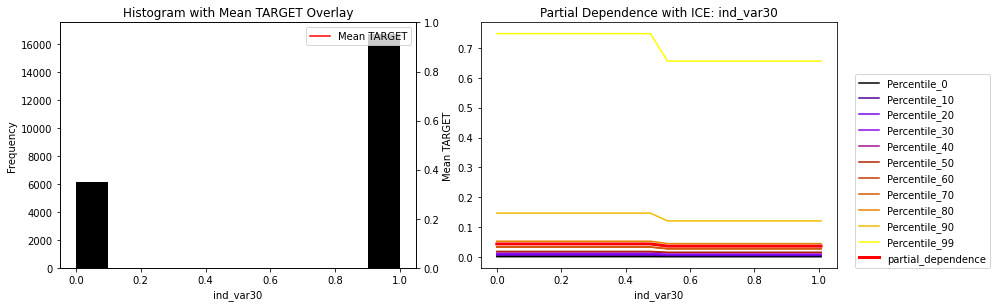

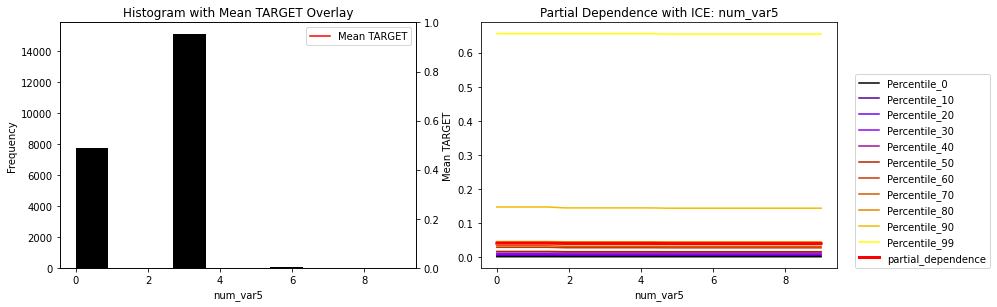

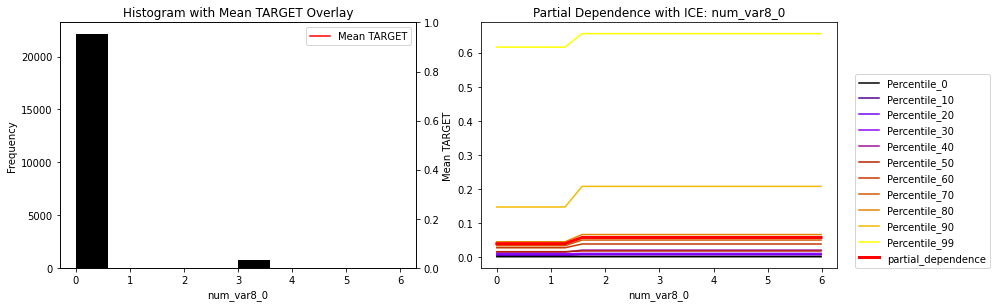

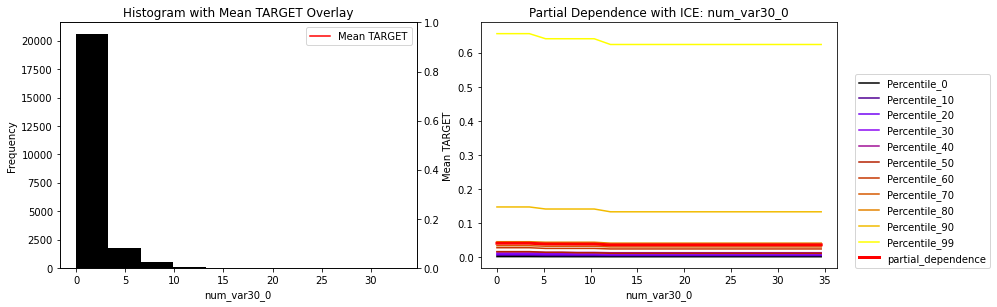

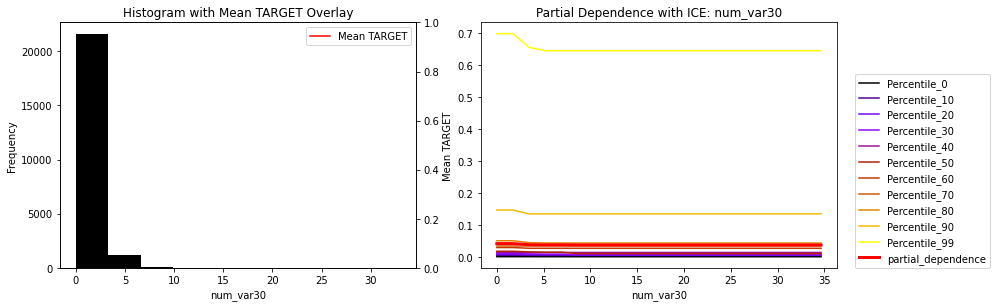

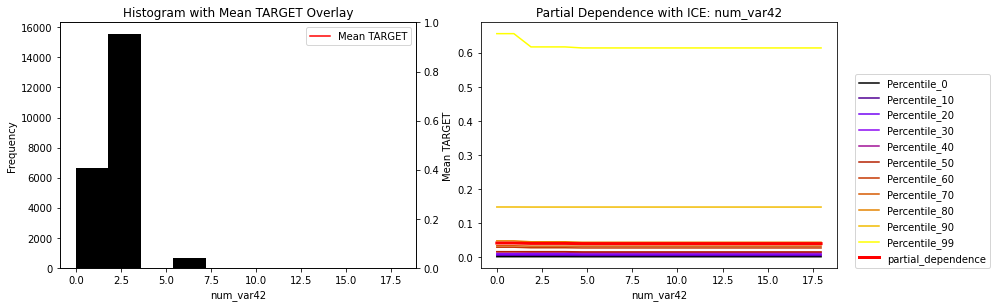

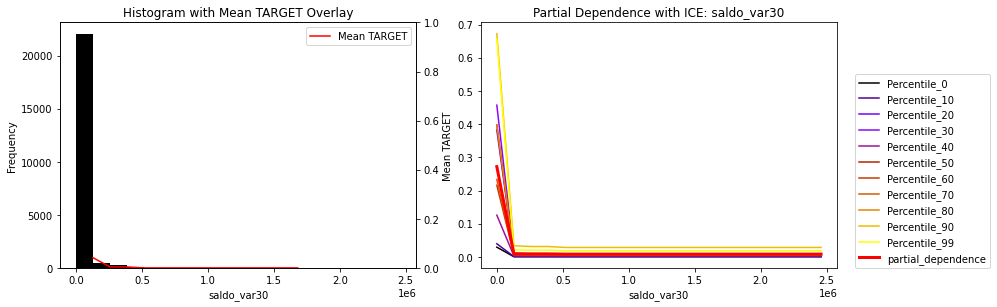

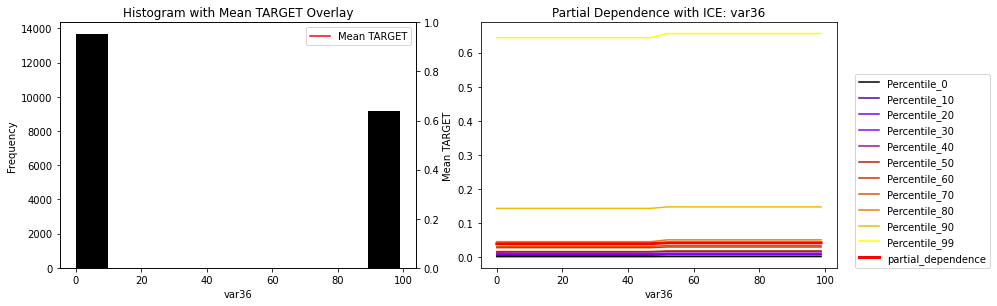

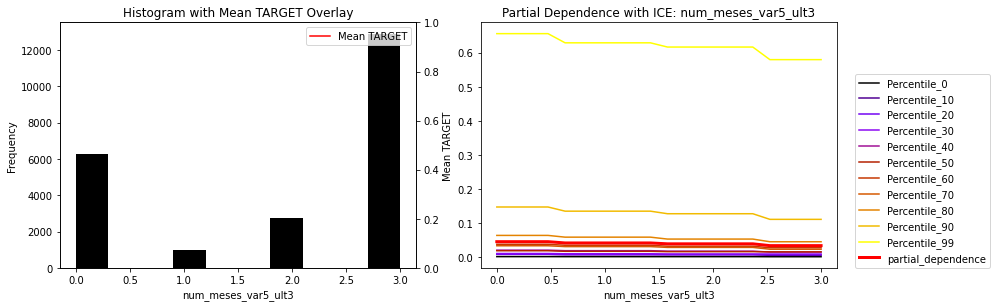

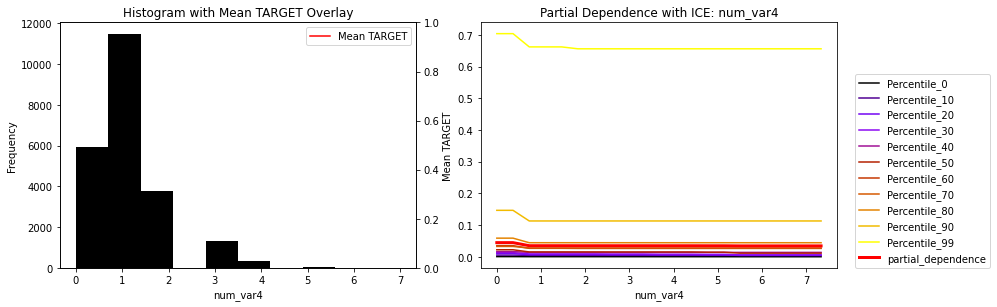

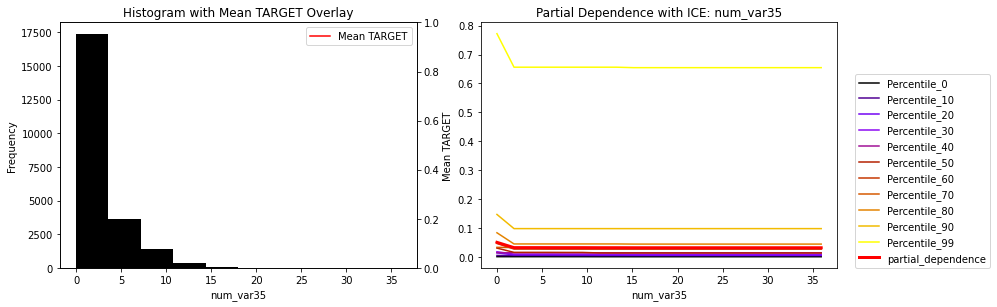

In [36]:
for xs in mgbm_selected: 
    explain.hist_mean_pd_ice_plot(xs, y_name, valid, mgbm_pd_ice_dict)

#### Save model

In [37]:
best_mgbm.model_id = 'best_mgbm'
h2o.save_model(best_mgbm, force=True)

'C:\\Users\\nh112\\GWU_rml\\best_mgbm'

#### End global timer

In [38]:
big_toc = time.time() - big_tic
print('All tasks completed in %.2f s.' % (big_toc))

All tasks completed in 1013.22 s.


#### Shutdown H2O

In [39]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_a89b closed.
